This file is based on the file [First Steps with TensorFlow](https://colab.research.google.com/notebooks/mlcc/first_steps_with_tensor_flow.ipynb?utm_source=mlcc&utm_campaign=colab-external&utm_medium=referral&utm_content=firststeps-colab&hl=en), which is part of Google's [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/).

In [1]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# First Steps with TensorFlow.jl

**Learning Objectives:**
  * Learn fundamental TensorFlow concepts
  * Building a linear regressor in TensorFlow to predict median housing price, at the granularity of city blocks, based on one input feature
  * Evaluate the accuracy of a model's predictions using Root Mean Squared Error (RMSE)
  * Improve the accuracy of a model by tuning its hyperparameters

The [data](https://developers.google.com/machine-learning/crash-course/california-housing-data-description) is based on 1990 census data from California. The training data can be downloaded [here](https://storage.googleapis.com/mledu-datasets/california_housing_train.csv).

## Setup
In this first cell, we'll load the necessary libraries.

In [2]:
using Plots
gr(fmt=:png)
using DataFrames
using TensorFlow
import CSV
using Random
using Statistics
#using PyCall

Start a new TensorFlow session.

In [3]:
sess=Session()

2019-02-24 13:47:01.083074: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.2 AVX AVX2 FMA


Session(Ptr{Nothing} @0x0000000110add890)

Next, we'll load our data set.

In [4]:
california_housing_dataframe = CSV.read("california_housing_train.csv", delim=",");

We'll randomize the data, just to be sure not to get any pathological ordering effects that might harm the performance of Stochastic Gradient Descent. Additionally, we'll scale `median_house_value` to be in units of thousands, so it can be learned a little more easily with learning rates in a range that we usually use.

In [5]:
california_housing_dataframe = california_housing_dataframe[Random.shuffle(1:size(california_housing_dataframe, 1)),:];
california_housing_dataframe[:median_house_value] /= 1000.0
california_housing_dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64
1,-122.43,37.66,29.0,3541.0,786.0,2259.0,770.0,4.3039,278.4
2,-117.99,33.89,23.0,2111.0,306.0,979.0,288.0,8.5621,347.8
3,-118.42,34.27,33.0,1209.0,341.0,1097.0,283.0,1.6295,134.3
4,-121.26,38.13,38.0,1419.0,411.0,1226.0,397.0,2.2188,68.8
5,-118.22,34.05,34.0,1113.0,313.0,928.0,290.0,3.1654,155.0
6,-121.98,37.37,36.0,1651.0,344.0,1062.0,331.0,4.575,215.4
7,-118.44,34.02,37.0,1592.0,308.0,783.0,321.0,6.2583,386.0
8,-121.88,37.35,49.0,1728.0,350.0,1146.0,391.0,3.5781,193.0
9,-119.64,37.31,15.0,2654.0,530.0,1267.0,489.0,2.8393,104.4


## Examine the Data

It's a good idea to get to know your data a little bit before you work with it.

We'll print out a quick summary of a few useful statistics on each column: count of examples, mean, standard deviation, max, min, and various quantiles.

In [6]:
describe(california_housing_dataframe)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Nothing,Union…,DataType
1,longitude,-119.562,-124.35,-118.49,-114.31,,0,Float64
2,latitude,35.6252,32.54,34.25,41.95,,0,Float64
3,housing_median_age,28.5894,1.0,29.0,52.0,,0,Float64
4,total_rooms,2643.66,2.0,2127.0,37937.0,,0,Float64
5,total_bedrooms,539.411,1.0,434.0,6445.0,,0,Float64
6,population,1429.57,3.0,1167.0,35682.0,,0,Float64
7,households,501.222,1.0,409.0,6082.0,,0,Float64
8,median_income,3.88358,0.4999,3.5446,15.0001,,0,Float64
9,median_house_value,207.301,14.999,180.4,500.001,,,Float64


## Build the First Model

In this exercise, we'll try to predict `median_house_value`, which will be our label (sometimes also called a target). We'll use `total_rooms` as our input feature.

**NOTE:** Our data is at the city block level, so this feature represents the total number of rooms in that block.

To train our model, we'll set up a linear regressor model.

### Step 1: Define Features and Configure Feature Columns

In order to import our training data into TensorFlow, we need to specify what type of data each feature contains. There are two main types of data we'll use in this and future exercises:

* **Categorical Data**: Data that is textual. In this exercise, our housing data set does not contain any categorical features, but examples you might see would be the home style, the words in a real-estate ad.

* **Numerical Data**: Data that is a number (integer or float) and that you want to treat as a number. As we will discuss more later sometimes you might want to treat numerical data (e.g., a postal code) as if it were categorical.

To start, we're going to use just one numeric input feature, `total_rooms`. The following code pulls the `total_rooms` data from our `california_housing_dataframe` and defines a feature and targer column:

In [7]:
# Define the input feature: total_rooms.
my_feature = california_housing_dataframe[:total_rooms]

# Configure a numeric feature column for total_rooms.
feature_columns = placeholder(Float32)
target_columns = placeholder(Float32)

<Tensor placeholder_2:1 shape=unknown dtype=Float32>

### Step 2: Define the Target

Next, we'll define our target, which is `median_house_value`. Again, we can pull it from our `california_housing_dataframe`:

In [8]:
# Define the label.
targets = california_housing_dataframe[:median_house_value];

### Step 3: Configure the LinearRegressor

Next, we'll configure a linear regression model using LinearRegressor. We'll train this model using the `GradientDescentOptimizer`, which implements Mini-Batch Stochastic Gradient Descent (SGD). The `learning_rate` argument controls the size of the gradient step.

**NOTE:** To be safe, we also apply [gradient clipping](https://developers.google.com/machine-learning/glossary/#gradient_clipping) to our optimizer via `clip_gradients_by_norm`. Gradient clipping ensures the magnitude of the gradients do not become too large during training, which can cause gradient descent to fail. 

In [9]:
# Configure the linear regression model with our feature columns and optimizer.
m=Variable(0.05)
b=Variable(0.0)
y=m.*feature_columns+b
loss=reduce_sum((target_columns - y).^2)

# Use gradient descent as the optimizer for training the model.
# Set a learning rate of 0.0000001 for Gradient Descent.
learning_rate=0.0000001;
my_optimizer=train.minimize(train.GradientDescentOptimizer(learning_rate), loss)
#gvs = train.compute_gradients(my_optimizer, loss)
#capped_gvs = [(clip_by_norm(grad, 5.), var) for (grad, var) in gvs]
#my_optimizer = train.apply_gradients(my_optimizer,capped_gvs)

<Tensor Group:1 shape=() dtype=Any>

### Step 4: Define the Input Function

To import our California housing data into our linear regressor model, we need to define an input function, which instructs TensorFlow how to preprocess
the data, as well as how to batch, shuffle, and repeat it during model training.

First, we'll convert our *DataFrame* feature data into an array. We can then construct a dataset object from our data, and then break our data into batches of `batch_size`, to be repeated for the specified number of epochs (num_epochs). 

**NOTE:** When the default value of `num_epochs=None` is passed to `repeat()`, the input data will be repeated indefinitely.

Next, if `shuffle` is set to `True`, we'll shuffle the data so that it's passed to the model randomly during training. The `buffer_size` argument specifies
the size of the dataset from which `shuffle` will randomly sample.

Finally, our input function constructs an iterator for the dataset and returns the next batch of data to the linear regressor.

In [10]:
function create_batches(features, targets, steps, batch_size=5, num_epochs=0)
    
    if(num_epochs==0)
        num_epochs=ceil(batch_size*steps/length(features))
    end
    
    features_batches=Union{Float64, Missings.Missing}[]
    target_batches=Union{Float64, Missings.Missing}[]
    
    for i=1:num_epochs
        select=Random.shuffle(1:length(features))
        append!(features_batches, features[select])
        append!(target_batches, targets[select])
    end
    
    return features_batches, target_batches 
end

create_batches (generic function with 3 methods)

In [11]:
function next_batch(features_batches, targets_batches, batch_size, iter)

    select=mod((iter-1)*batch_size+1, length(features_batches)):mod(iter*batch_size, length(features_batches));

    ds=features_batches[select];
    target=targets_batches[select];
    
    return ds, target
end
    

next_batch (generic function with 1 method)

In [12]:
function my_input_fn(features_batches, targets_batches, iter, batch_size=5, shuffle_flag=1)
    """Trains a linear regression model of one feature.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
                                          
 
    # Construct a dataset, and configure batching/repeating.
    ds, target = next_batch(features_batches, targets_batches, batch_size, iter)
    
    # Shuffle the data, if specified.
    if shuffle_flag==1
      select=Random.shuffle(1:size(ds, 1));
        ds = ds[select,:]
        target = target[select, :]
    end
    
    # Return the next batch of data.
    return convert(Matrix{Float64},ds), convert(Matrix{Float64},target)
end

my_input_fn (generic function with 3 methods)

**NOTE:** We'll continue to use this same input function in later exercises. 

### Step 5: Train the Model

We can now call `train()` on our `my_optimizer` to train the model. To start, we'll train for 100 steps.

In [13]:
steps=100;
batch_size=5;
run(sess, global_variables_initializer())
features_batches, targets_batches = create_batches(my_feature, targets, steps, batch_size)

for i=1:steps
    features, labels = my_input_fn(features_batches, targets_batches, i, batch_size)
    run(sess, my_optimizer, Dict(feature_columns=>features, target_columns=>labels))
end

We can assess the values for the weight and bias variables:

In [14]:
weight = run(sess,m)

-2.1643431694151094e86

In [15]:
bias = run(sess,b)

-1.184116157861517e83

### Step 6: Evaluate the Model

Let's make predictions on that training data, to see how well our model fit it during training.

**NOTE:** Training error measures how well your model fits the training data, but it **_does not_** measure how well your model **_generalizes to new data_**. In later exercises, you'll explore how to split your data to evaluate your model's ability to generalize.


In [16]:
# Run the TF session on the data to make predictions.
predictions = run(sess, y, Dict(feature_columns=>convert.(Float64, my_feature)));

# Print Mean Squared Error and Root Mean Squared Error.
mean_squared_error = mean((predictions- targets).^2);
root_mean_squared_error = sqrt(mean_squared_error);
println("Mean Squared Error (on training data): ", mean_squared_error)
println("Root Mean Squared Error (on training data): ", root_mean_squared_error)

Mean Squared Error (on training data): 5.499863808321752e179
Root Mean Squared Error (on training data): 7.416106666116495e89


Is this a good model? How would you judge how large this error is?

Mean Squared Error (MSE) can be hard to interpret, so we often look at Root Mean Squared Error (RMSE)
instead.  A nice property of RMSE is that it can be interpreted on the same scale as the original targets.

Let's compare the RMSE to the difference of the min and max of our targets:

In [17]:
min_house_value = minimum(california_housing_dataframe[:median_house_value])
max_house_value = maximum(california_housing_dataframe[:median_house_value])
min_max_difference = max_house_value - min_house_value

println("Min. Median House Value: " , min_house_value)
println("Max. Median House Value: " , max_house_value)
println("Difference between Min. and Max.: " , min_max_difference)
println("Root Mean Squared Error: " , root_mean_squared_error)

Min. Median House Value: 14.999
Max. Median House Value: 500.001
Difference between Min. and Max.: 485.00199999999995
Root Mean Squared Error: 7.416106666116495e89


Our error spans nearly half the range of the target values. Can we do better?

This is the question that nags at every model developer. Let's develop some basic strategies to reduce model error.

The first thing we can do is take a look at how well our predictions match our targets, in terms of overall summary statistics.

In [18]:
calibration_data = DataFrame();
calibration_data[:predictions] = predictions;
calibration_data[:targets] = targets;
describe(calibration_data)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Nothing,Nothing,DataType
1,predictions,-5.7218e89,-8.21087e90,-4.60356e89,-4.32987e86,,,Float64
2,targets,207.301,14.999,180.4,500.001,,,Float64


Okay, maybe this information is helpful. How does the mean value compare to the model's RMSE? How about the various quantiles?

We can also visualize the data and the line we've learned.  Recall that linear regression on a single feature can be drawn as a line mapping input *x* to output *y*.

First, we'll get a uniform random sample of the data so we can make a readable scatter plot.

In [19]:
sample = california_housing_dataframe[rand(1:size(california_housing_dataframe,1), 300),:];

Next, we'll plot the line we've learned, drawing from the model's bias term and feature weight, together with the scatter plot. The line will show up red.

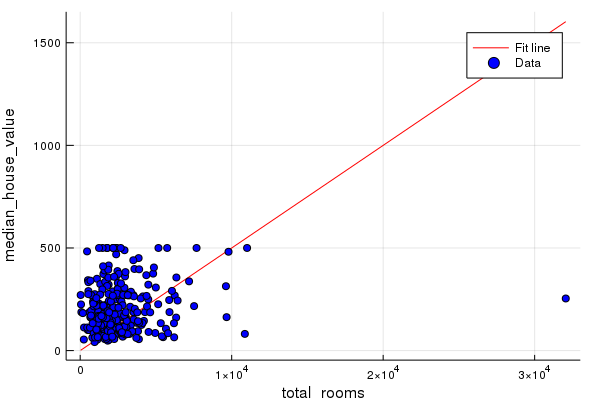

In [29]:
# Get the min and max total_rooms values.
x_0 = minimum(sample[:total_rooms])
x_1 = maximum(sample[:total_rooms])

# Retrieve the final weight and bias generated during training.
weight = run(sess,m)
bias = run(sess,b)

# Get the predicted median_house_values for the min and max total_rooms values.
y_0 = weight * x_0 + bias 
y_1 = weight * x_1 + bias

# Plot our regression line from (x_0, y_0) to (x_1, y_1).
plot([x_0, x_1], [y_0, y_1], c=:red, ylabel="median_house_value", xlabel="total_rooms", label="Fit line")

# Plot a scatter plot from our data sample.
scatter!(sample[:total_rooms], sample[:median_house_value], c=:blue, label="Data")

In [21]:
input_feature=:total_rooms

:total_rooms

This initial line looks way off.  See if you can look back at the summary stats and see the same information encoded there.

Together, these initial sanity checks suggest we may be able to find a much better line.

## Tweak the Model Hyperparameters
For this exercise, we've put all the above code in a single function for convenience. You can call the function with different parameters to see the effect.

In this function, we'll proceed in 10 evenly divided periods so that we can observe the model improvement at each period.

For each period, we'll compute and graph training loss.  This may help you judge when a model is converged, or if it needs more iterations.

We'll also plot the feature weight and bias term values learned by the model over time.  This is another way to see how things converge.

In [22]:
function train_model(learning_rate, steps, batch_size, input_feature=:total_rooms)
  """Trains a linear regression model of one feature.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    input_feature: A `string` specifying a column from `california_housing_dataframe`
      to use as input feature.
  """
  
  periods = 10
  steps_per_period = steps / periods

  my_feature = input_feature
  my_feature_data = convert.(Float32,california_housing_dataframe[my_feature])
  my_label = :median_house_value
  targets = convert.(Float32,california_housing_dataframe[my_label])

  # Create feature columns.
  feature_columns = placeholder(Float32)
  target_columns = placeholder(Float32)
  
  # Create a linear regressor object.
  # Configure the linear regression model with our feature columns and optimizer.
  m=Variable(0.0)
  b=Variable(0.0)
  y=m.*feature_columns .+ b
  loss=reduce_sum((target_columns - y).^2)
  features_batches, targets_batches = create_batches(my_feature_data, targets, steps, batch_size)
    
  # Use gradient descent as the optimizer for training the model.
  my_optimizer=(train.GradientDescentOptimizer(learning_rate))
  gvs = train.compute_gradients(my_optimizer, loss)
  capped_gvs = [(clip_by_norm(grad, 5.), var) for (grad, var) in gvs]
  my_optimizer = train.apply_gradients(my_optimizer,capped_gvs)
  
  run(sess, global_variables_initializer())
    
  # Set up to plot the state of our model's line each period.
  sample = california_housing_dataframe[rand(1:size(california_housing_dataframe,1), 300),:];
  p1=scatter(sample[my_feature], sample[my_label], title="Learned Line by Period", ylabel=my_label, xlabel=my_feature,color=:coolwarm)
  colors= [ColorGradient(:coolwarm)[i] for i in range(0,stop=1, length=periods+1)]

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  println("Training model...")
  println("RMSE (on training data):")
  root_mean_squared_errors = []
  for period in 1:periods
    # Train the model, starting from the prior state.
   for i=1:steps_per_period
    features, labels = my_input_fn(features_batches, targets_batches, convert(Int,(period-1)*steps_per_period+i), batch_size)
    run(sess, my_optimizer, Dict(feature_columns=>features, target_columns=>labels))
   end
    # Take a break and compute predictions.
    predictions = run(sess, y, Dict(feature_columns=>convert.(Float64, my_feature_data)));
        
    # Compute loss.
     mean_squared_error = mean((predictions- targets).^2)
     root_mean_squared_error = sqrt(mean_squared_error)
    # Occasionally print the current loss.
    println("  period ", period, ": ", root_mean_squared_error)
    # Add the loss metrics from this period to our list.
    push!(root_mean_squared_errors, root_mean_squared_error)
    # Finally, track the weights and biases over time.
    
    # Apply some math to ensure that the data and line are plotted neatly.
    y_extents = [0 maximum(sample[my_label])]
   
    weight = run(sess,m)
    bias = run(sess,b)
           
    x_extents = (y_extents .- bias) / weight    
    x_extents = max.(min.(x_extents, maximum(sample[my_feature])),
                           minimum(sample[my_feature]))    
    y_extents = weight .* x_extents .+ bias 
        
    p1=plot!(x_extents', y_extents', color=colors[period], linewidth=2) 
 end
                
  println("Model training finished.")

  # Output a graph of loss metrics over periods.
  p2=plot(root_mean_squared_errors, title="Root Mean Squared Error vs. Periods", ylabel="RMSE", xlabel="Periods")
                             
  # Output a table with calibration data.
  calibration_data = DataFrame()
  calibration_data[:predictions] = predictions
  calibration_data[:targets] = targets
  describe(calibration_data)

  println("Final RMSE (on training data): ", root_mean_squared_errors[end])
  println("Final Weight (on training data): ", weight)
  println("Final Bias (on training data): ", bias)

  return p1, p2      
end

train_model (generic function with 2 methods)

## Task 1:  Achieve an RMSE of 180 or Below

Tweak the model hyperparameters to improve loss and better match the target distribution.
If, after 5 minutes or so, you're having trouble beating a RMSE of 180, check the solution for a possible combination.

In [23]:
sess=Session()
p1, p2= train_model(
    0.0001, # learning rate
    20, # steps
    5 # batch size
)

Training model...
RMSE (on training data):
  period 1: 235.10452754834785
  period 2: 232.69434701416756
  period 3: 230.30994696291228
  period 4: 227.95213639459652
  period 5: 225.62174891342735
  period 6: 223.31964301811482
  period 7: 221.04670233191547
  period 8: 218.80383576386936
  period 9: 216.59197759206555
  period 10: 214.4120874591565
Model training finished.
Final RMSE (on training data): 214.4120874591565
Final Weight (on training data): -2.1643431694151094e86
Final Bias (on training data): -1.184116157861517e83


(Plot{Plots.GRBackend() n=11}, Plot{Plots.GRBackend() n=1})

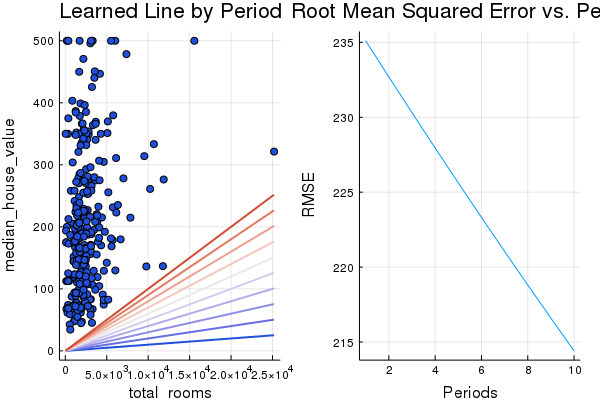

In [24]:
plot(p1, p2, layout=(1,2), legend=false)

### Solution

Click below for one possible solution.

In [25]:
p1, p2= train_model(
    0.001, # learning rate
    20, # steps
    5 # batch size
)

Training model...
RMSE (on training data):
  period 1: 214.4120874591565
  period 2: 194.600111798902
  period 3: 179.20684050800634
  period 4: 169.44086805355906
  period 5: 169.434877106273
  period 6: 166.2920638633921
  period 7: 170.13862388370202
  period 8: 180.52860974790764
  period 9: 170.13354759178128
  period 10: 180.5261550915958
Model training finished.
Final RMSE (on training data): 180.5261550915958
Final Weight (on training data): -2.1643431694151094e86
Final Bias (on training data): -1.184116157861517e83


(Plot{Plots.GRBackend() n=11}, Plot{Plots.GRBackend() n=1})

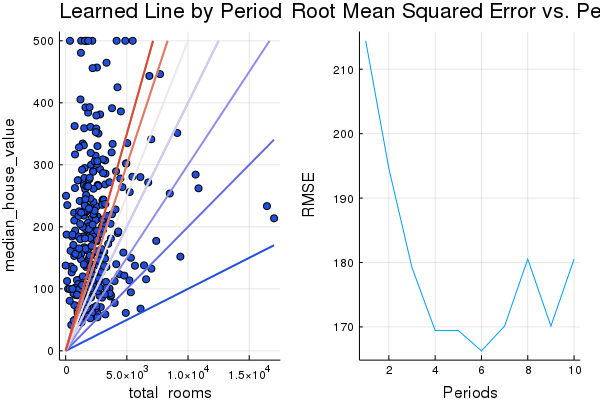

In [26]:
plot(p1, p2, layout=(1,2), legend=false)

This is just one possible configuration; there may be other combinations of settings that also give good results. Note that in general, this exercise isn't about finding the *one best* setting, but to help build your intutions about how tweaking the model configuration affects prediction quality.

### Is There a Standard Heuristic for Model Tuning?

This is a commonly asked question. The short answer is that the effects of different hyperparameters are data dependent. So there are no hard-and-fast rules; you'll need to test on your data.

That said, here are a few rules of thumb that may help guide you:

 * Training error should steadily decrease, steeply at first, and should eventually plateau as training converges.
 * If the training has not converged, try running it for longer.
 * If the training error decreases too slowly, increasing the learning rate may help it decrease faster.
   * But sometimes the exact opposite may happen if the learning rate is too high.
 * If the training error varies wildly, try decreasing the learning rate.
   * Lower learning rate plus larger number of steps or larger batch size is often a good combination.
 * Very small batch sizes can also cause instability.  First try larger values like 100 or 1000, and decrease until you see degradation.

Again, never go strictly by these rules of thumb, because the effects are data dependent.  Always experiment and verify.

## Task 2: Try a Different Feature

See if you can do any better by replacing the `total_rooms` feature with the `population` feature.

In [27]:
# YOUR CODE HERE
p1, p2= train_model(
    0.0001, # learning rate
    300, # steps
    5, # batch size
    :population #feature
)

Training model...
RMSE (on training data):
  period 1: 219.9919658470582
  period 2: 204.6500256564945
  period 3: 194.31631437316608
  period 4: 185.43549863077988
  period 5: 179.30763919257313
  period 6: 176.34328658344398
  period 7: 175.86576786417197
  period 8: 176.0115967111658
  period 9: 176.62469585550392
  period 10: 176.460123907991
Model training finished.
Final RMSE (on training data): 176.460123907991
Final Weight (on training data): -2.1643431694151094e86
Final Bias (on training data): -1.184116157861517e83


(Plot{Plots.GRBackend() n=11}, Plot{Plots.GRBackend() n=1})

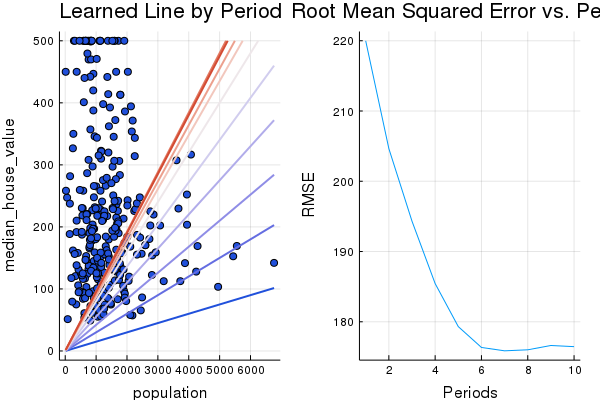

In [28]:
plot(p1, p2, layout=(1,2), legend=false)